# Soil Type Image Classification with TensorFlow and Keras

In this project, we will use Python with TensorFlow and Keras to build a deep learning neural network that can classify images of soil types.  

## Real World Applications:

Soil type classification is essential for agriculture, construction, environmental management, and more. It helps farmers choose the right crops and manage soil fertility, improving yields and water efficiency. In construction, understanding soil properties ensures safe, durable foundations and infrastructure. It also aids in flood risk assessment, erosion control, and habitat restoration. Soil classification informs water management by determining how water moves through the ground, supporting aquifer recharge and pollutant filtration. Additionally, it plays a key role in disaster resilience, helping assess earthquake risks and slope stability. In climate change research, soil classification helps track carbon storage and its impact on temperature regulation. Overall, soil classification supports better decision-making across various sectors, contributing to sustainability, resource management, and environmental protection.

## Import all Necessary Libraries

In [ ]:
# To visualize images in the dataset
import matplotlib.pyplot as plt
# For mathematical computations
import numpy as np
# For Image processing
import PIL
# To find all pathnames matching a specified pattern (for file searching)
import glob
# For machine learning and deep learning
import tensorflow as tf
# Keras is a high-level neural networks API integrated into TensorFlow that simplifies model creation, training, and evaluation
from tensorflow import keras
# To import the layers module from Keras
from tensorflow.keras import layers
# To build a neural network model layer-by-layer in a simple, linear way
from tensorflow.keras.models import Sequential

## Download and Visualize the Dataset

The dataset used is **'Soil Types'** by Prasansha Satpathy. You can download it from Kaggle by following this link:
https://www.kaggle.com/datasets/prasanshasatpathy/soil-types

The dataset consists of 156 images of 5 varieties of soil images spread across 5 directories (folders).

There are 5 soil types (classes) in our dataset - Black Soil, Cinder Soil, Laterite Soil, Peat Soil, Yellow Soil.



In [ ]:
# Install 'opendatasets'. If you already have the package installed, please leave this line of code as a comment and proceed.

# pip install opendatasets

In [ ]:
# To easily download datasets from online sources like Kaggle using one line of Python code
import opendatasets as od

In [ ]:
# Paste the link to the dataset here. You will need to enter your Kaggle username and API key (found in your Kaggle account) when prompted.

od.download(
    "https://www.kaggle.com/datasets/prasanshasatpathy/soil-types")

***The following output will be generated. You will need to enter your Kaggle username and password.*** 

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds

Your Kaggle username: ··········

Your Kaggle Key: ··········

Dataset URL: https://www.kaggle.com/datasets/prasanshasatpathy/soil-types

Downloading soil-types.zip to ./soil-types

100%|██████████| 3.08M/3.08M [00:00<00:00, 159MB/s]


**PLEASE NOTE**: The names of the folders in the originally downloaded dataset have been slightly modified to remove the space between the words. This helps wth avoiding possible errors.

In [ ]:
# Specify the file path (the location of your dataset folder)

data_dir = "/content/soil-types/Soil_types"

In [ ]:
# Convert to a path which is required if we want to use 'glob'

from pathlib import Path

data_path = Path(data_dir)

In [ ]:
# Find the number of images in the dataset

image_count = len(list(data_path.glob('*/*.jpg')))
print(image_count)

156


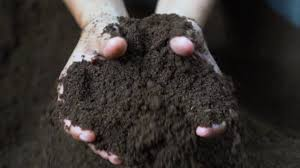

In [ ]:
# Open the first image in the specified sub-directory in the dataset

soil_type = list(data_path.glob('Black/*'))
PIL.Image.open(str(soil_type[0]))

********

********

## Load and Preprocess the Data Using a Keras Utility

We will now load and preprocess image data for training a deep learning model. We will load the images from the directory, split them into training and validation sets, resize them to a specified size, and organize them into batches.

### Create a dataset

We will start by defining some parameters for the loader. We will use the following -

* batch_size: This specifies the number of images in each batch. During training, instead of passing all images through the network at once (which would be inefficient and memory-intensive), the images are processed in small batches.
* img_height: The required height of the image.
* img_width: The required width of the image.


In [ ]:
batch_size = 32
img_height = 180
img_width = 180

This piece of code is used to create a training dataset from all the images. It loads images from a directory, splits them into training and validation sets, resizes them to a specified size, and organizes them into batches.

Here's a breakdown of the parameters -

* data_path: This is the path to the directory where your image data is stored. The images in this directory should be organized in subdirectories where each subdirectory corresponds to a class label.

* This parameter defines the fraction of data to be used for the validation set. In this case, 20% of the data will be set aside for validation, and 80% will be used for training. The data will be split randomly, and the training and validation sets will

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 156 files belonging to 5 classes.
Using 125 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

You can find the class names in the class_names attribute on these datasets. These correspond to the directory names in alphabetical order.

In [ ]:
class_names = train_ds.class_names
print(class_names)

['Black', 'Cinder', 'Laterite', 'Peat', 'Yellow']


### Visualize the data

Here are the first nine images from the training dataset:



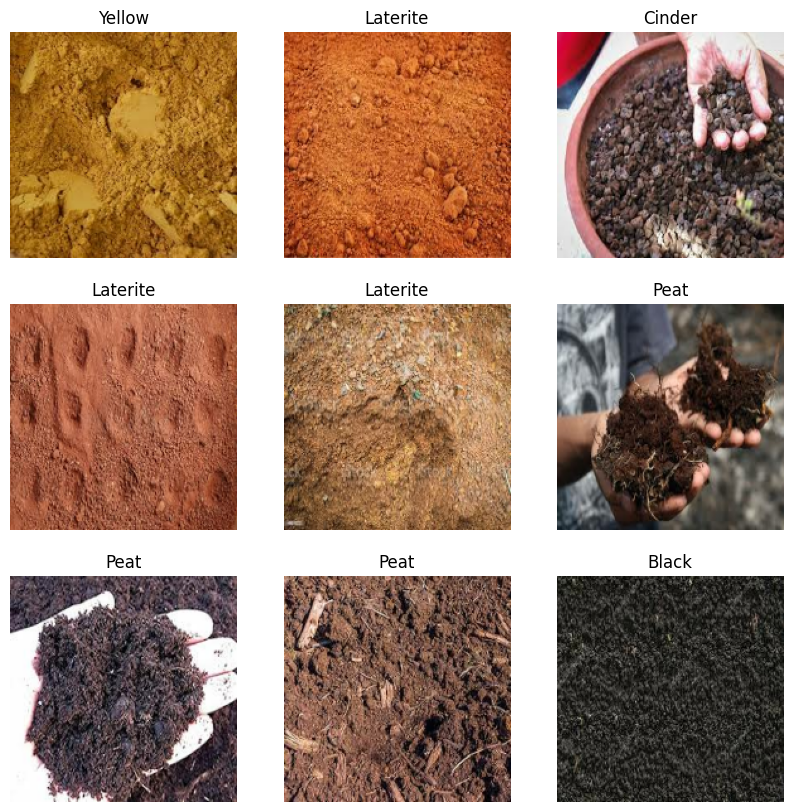

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

You will pass these datasets to the Keras Model.fit method for training later in this tutorial. If you like, you can also manually iterate over the dataset and retrieve batches of images:

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

You can call .numpy() on the image_batch and labels_batch tensors to convert them to a numpy.ndarray.

### Standardize the data

The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the [0, 1] range by using tf.keras.layers.Rescaling:

In [ ]:
normalization_layer = layers.Rescaling(1./255)

There are two ways to use this layer. You can apply it to the dataset by calling Dataset.map, or, you can include the layer inside your model definition, which can simplify deployment. We will use the second approach here.



## A Basic Keras Model

### Create the Model

The Keras Sequential model consists of three convolution blocks (tf.keras.layers.Conv2D) with a max pooling layer (tf.keras.layers.MaxPooling2D) in each of them. There's a fully-connected layer (tf.keras.layers.Dense) with 128 units on top of it that is activated by a ReLU activation function ('relu'). This model has not been tuned for high accuracy; the goal of this tutorial is to show a standard approach.

In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Compile the Model

For this tutorial, choose the tf.keras.optimizers.Adam optimizer and tf.keras.losses.SparseCategoricalCrossentropy loss function. To view training and validation accuracy for each training epoch, pass the metrics argument to Model.compile.

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Model Summary

View all the layers of the network using the Keras Model.summary method:



In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,285 (15.22 MB)

 Trainable params: 3,989,285 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

### Train the Model

Train the model for 10 epochs with the Keras Model.fit method:



In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.1964 - loss: 2.0773 - val_accuracy: 0.2581 - val_loss: 1.5726
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 960ms/step - accuracy: 0.2672 - loss: 1.5158 - val_accuracy: 0.3871 - val_loss: 1.3636
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.4259 - loss: 1.3108 - val_accuracy: 0.2903 - val_loss: 1.1914
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 975ms/step - accuracy: 0.4590 - loss: 1.0533 - val_accuracy: 0.5484 - val_loss: 1.2248
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 963ms/step - accuracy: 0.6171 - loss: 0.8744 - val_accuracy: 0.3871 - val_loss: 0.9426
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.7006 - loss: 0.6620 - val_accuracy: 0.6129 - val_loss: 0.9957
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.9033 - loss: 0.4241 - val_accuracy: 0.5806 - val_loss: 0.8887
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 984ms/step - accuracy: 0.8656 - loss: 0.4137 - val_accuracy: 0.6452 - val_loss: 1.0200
Epoc

### Visualize the Training Results

Create plots of the loss and accuracy on the training and validation sets:



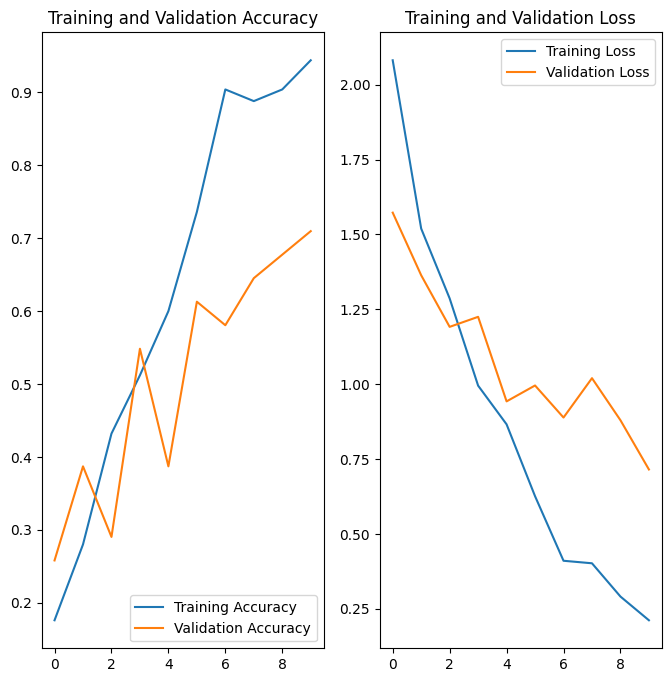

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The plots show that training accuracy and validation accuracy increased, while the training loss and validation loss decreased with each epoch.

******

## Predict on New Data

Use your model to classify an image that wasn't included in the training or validation sets.

To do this, we will get random images from a Google search online, and we will save them as 'soil1' (Peat), 'soil2' (Red), 'soil3' (Yellow), 'soil4' (Cinder), and 'soil5' (Black).






We can make a prediction for a single image using the code below.

In [ ]:
inf_url = "/content/inference/soil1.jpeg"
inf_path = Path(inf_url)

img = tf.keras.utils.load_img(
    inf_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
This image most likely belongs to Black with a 92.69 percent confidence.


If we want, we can make a prediction for all the images in our 'inference' folder by iterating through the folder.

In [ ]:
from tensorflow.keras.preprocessing import image


inf_url = "/content/inference"
inf_path = Path(inf_url)

for img_path in inf_path.glob('*.jpeg'):  # Adjust the pattern for the image file type
    img = image.load_img(img_path, target_size=(img_height, img_width))
    img_array = image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create a batch
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    print("Image: {} - This image most likely belongs to {} with a {:.2f} percent confidence.".format(
            img_path.name,  # Displaying the image name
            class_names[np.argmax(score)],
            100 * np.max(score)
        )
    )

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Image: soil1.jpeg - This image most likely belongs to Black with a 92.69 percent confidence.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Image: soil3.jpeg - This image most likely belongs to Yellow with a 97.40 percent confidence.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Image: soil5.jpeg - This image most likely belongs to Black with a 89.82 percent confidence.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Image: soil4.jpeg - This image most likely belongs to Cinder with a 96.19 percent confidence.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Image: soil2.jpeg - This image most likely belongs to Laterite with a 97.70 percent confidence.


After testing all the images, we find that 'soil1' is predicted incorrectly, while the rest are predicted correctly.
Further training and validation can help with completely preventing errors in the model's predictions. 